### Adult Dataset

The Adult Census Income dataset consists of demographic information about individuals. This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics) and in addition, this specific dataset is downloaded from kaggle. This dataset includes multiple variables that could potentially influence income, which is the target variable. Here’s a summary of the variables:

- Age: The age of the individual

- Workclass: Type of WorkSector

- fnlwgt: weighted tallies of any specified socio-economic characteristics of the population.

- education: Education Level (Categorical)

- Education.num: Education-level (numeric)

- Martial.status: Martial Status of that individual

- Occupation: Current job of that individual

- Relationship: Relationship Status of that individual

- Race: Race of that individual

- Sex: Gender of that individual

- Capital.gain: Capital gains (Additional income from income)

- Capital.loss: Capital losses

- Hours.per.week: Hours per week an individual works for

- Native.country: Country of origin for that individual

- Income: Income category indicating if the individual earns more or less than $50K

It seems like there are 32651 rows and 15 columns which is a pretty good size for an analysis. Some variables also contain "?" which indicate missing values on some rows. 

### Question Of Interest

Is there a significant income disparity between male and female individuals, and how do other factors like occupation and hours worked per week influence this disparity?

Response Variable: Income

Explanatory Variables:

- sex: This variable directly addresses gender differences in income.
- occupation: Some occupations might have different earning potential based on gender.
- hours.per.week: Examining if hours worked per week contribute to income disparities between genders.


This question focuses on inference to understand the factors influencing gender-based income disparities, providing insights into whether these disparities persist across occupations and work hours.

### Importing Libraries

In [22]:
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(broom)
library(ggplot2)
library(leaps)
library(glmnet)

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8



In [2]:
adult_df <- read_csv("data/adult.csv")

head(adult_df)
dim(adult_df)

Rows: 32561 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): workclass, education, marital.status, occupation, relationship, rac...
dbl (6): age, fnlwgt, education.num, capital.gain, capital.loss, hours.per.week

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K


[1] 32561    15

In [3]:
summary(adult_df)

      age         workclass             fnlwgt         education        
 Min.   :17.00   Length:32561       Min.   :  12285   Length:32561      
 1st Qu.:28.00   Class :character   1st Qu.: 117827   Class :character  
 Median :37.00   Mode  :character   Median : 178356   Mode  :character  
 Mean   :38.58                      Mean   : 189778                     
 3rd Qu.:48.00                      3rd Qu.: 237051                     
 Max.   :90.00                      Max.   :1484705                     
 education.num   marital.status      occupation        relationship      
 Min.   : 1.00   Length:32561       Length:32561       Length:32561      
 1st Qu.: 9.00   Class :character   Class :character   Class :character  
 Median :10.00   Mode  :character   Mode  :character   Mode  :character  
 Mean   :10.08                                                           
 3rd Qu.:12.00                                                           
 Max.   :16.00                               

In [4]:
colSums(is.na(adult_df))

age      workclass         fnlwgt      education  education.num 
             0              0              0              0              0 
marital.status     occupation   relationship           race            sex 
             0              0              0              0              0 
  capital.gain   capital.loss hours.per.week native.country         income 
             0              0              0              0              0

In [5]:
colSums(adult_df=="?")

age      workclass         fnlwgt      education  education.num 
             0           1836              0              0              0 
marital.status     occupation   relationship           race            sex 
             0           1843              0              0              0 
  capital.gain   capital.loss hours.per.week native.country         income 
             0              0              0            583              0

It seems like there are missing values in workclass, occupation and the native country values. We can input the correct ratio of the categorical variables to ensure we maintain the spread of the data, thus using proportional imputation.

In [6]:
fill_with_proportion <- function(column) 
{
  non_missing <- column[column != "?"]
  value_counts <- table(non_missing)
  proportions <- prop.table(value_counts)
  
  column[column == "?"] <- sample(names(proportions), sum(column == "?"), replace = TRUE, prob = proportions)
  
  return(column)
}

adult_df$workclass <- fill_with_proportion(adult_df$workclass)
adult_df$occupation <- fill_with_proportion(adult_df$occupation)
adult_df$native.country <- fill_with_proportion(adult_df$native.country)

colSums(adult_df=="?")

age      workclass         fnlwgt      education  education.num 
             0              0              0              0              0 
marital.status     occupation   relationship           race            sex 
             0              0              0              0              0 
  capital.gain   capital.loss hours.per.week native.country         income 
             0              0              0              0              0

Now, we should check for duplicate rows.

In [7]:
duplicates <- adult_df[duplicated(adult_df), ]

if (nrow(duplicates) > 0) {
  print(duplicates)
} else {
  print("No duplicate rows found.")
}

# A tibble: 24 × 15
     age workclass fnlwgt education    education.num marital.status   occupation
   <dbl> <chr>      <dbl> <chr>                <dbl> <chr>            <chr>     
 1    25 Private   308144 Bachelors               13 Never-married    Craft-rep…
 2    90 Private    52386 Some-college            10 Never-married    Other-ser…
 3    21 Private   250051 Some-college            10 Never-married    Prof-spec…
 4    20 Private   107658 Some-college            10 Never-married    Tech-supp…
 5    25 Private   195994 1st-4th                  2 Never-married    Priv-hous…
 6    21 Private   243368 Preschool                1 Never-married    Farming-f…
 7    46 Private   173243 HS-grad                  9 Married-civ-spo… Craft-rep…
 8    30 Private   144593 HS-grad                  9 Never-married    Other-ser…
 9    19 Private    97261 HS-grad                  9 Never-married    Farming-f…
10    19 Private   138153 Some-college            10 Never-married    Adm-cleri…
# ℹ 14 m

Seems like there are 24 rows of duplicated data. This may be an input error from employees doing data entry or the system having errors. We will remove all of them.

In [8]:
adult_df <- distinct(adult_df)
dim(adult_df)

[1] 32537    15

Now, we are ready to do EDA on this dataset.

### EDA

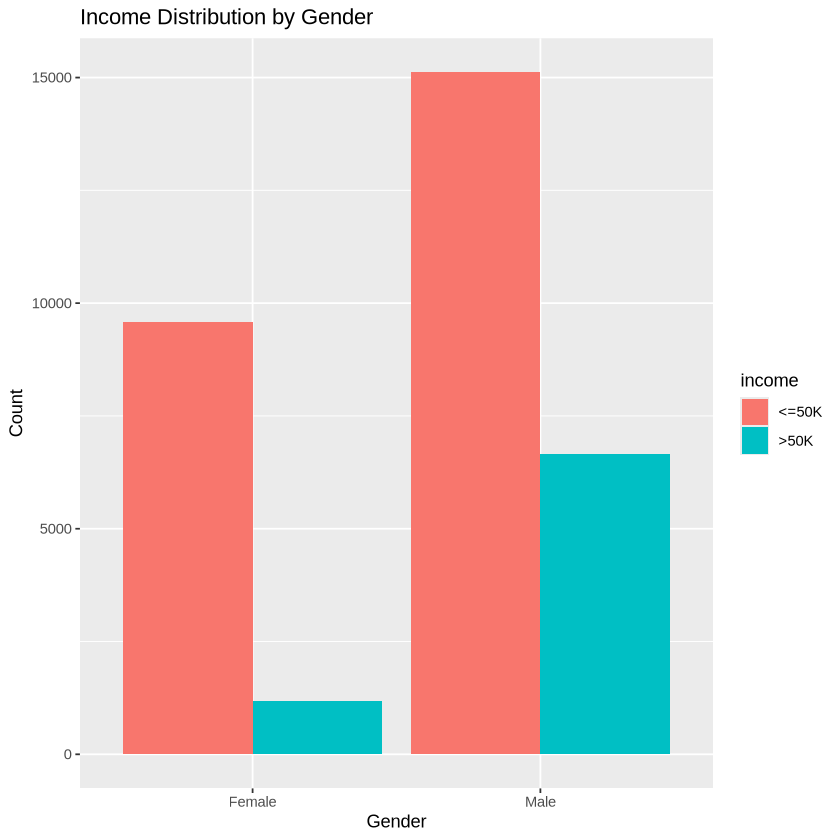

In [9]:
income_sex_barplot <- ggplot(adult_df, aes(x = sex, fill = income)) +
                      geom_bar(position = "dodge") +
                      labs(title = "Income Distribution by Gender", x = "Gender", y = "Count") 

income_sex_barplot

It appears that a larger proportion of males earn more than $50K compared to females. In addition, females have a higher count in the <=50K income category than in the >50K category, suggesting a difference in ratio.

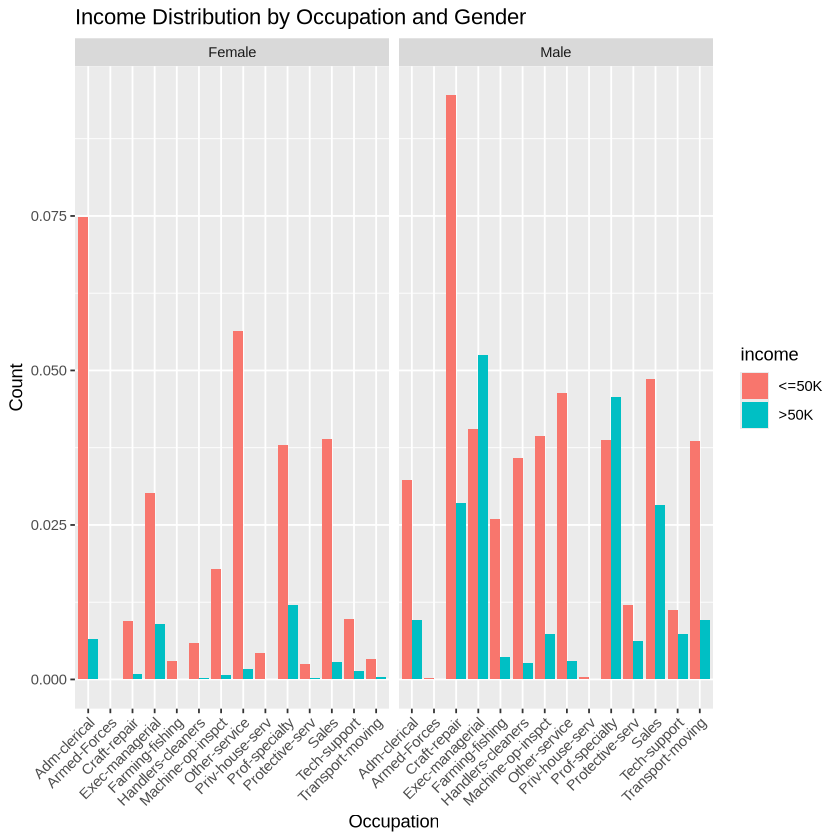

In [10]:
adult_df_proportions <- adult_df |>
  group_by(occupation, sex, income) |>
  summarise(count = n(), .groups = 'drop') |>
  mutate(proportion = count / sum(count))

occupation_sex_income_plot <- ggplot(adult_df_proportions, aes(x = occupation, y = proportion, fill = income)) +
                              geom_bar(stat = "identity", position = "dodge") +
                              facet_wrap(~sex) +
                              labs(title = "Income Distribution by Occupation and Gender", x = "Occupation", y = "Count") +
                              theme(axis.text.x = element_text(angle = 45, hjust = 1))
occupation_sex_income_plot

This bar graph shows the distribution of income through different occupations between male and female individuals. Males tend to have a higher proportion of individuals earning more than 50K compared to females across most occupations such as "Exec-managerial". This suggests potential gender disparities in income. In addition, there are some occupations like "Handlers-cleaners," "Other-service," and "Priv-house-serv" have a predominantly larger proportion of individuals earning less than 50K for both genders. We need to examine more relationships between men and women income levels.

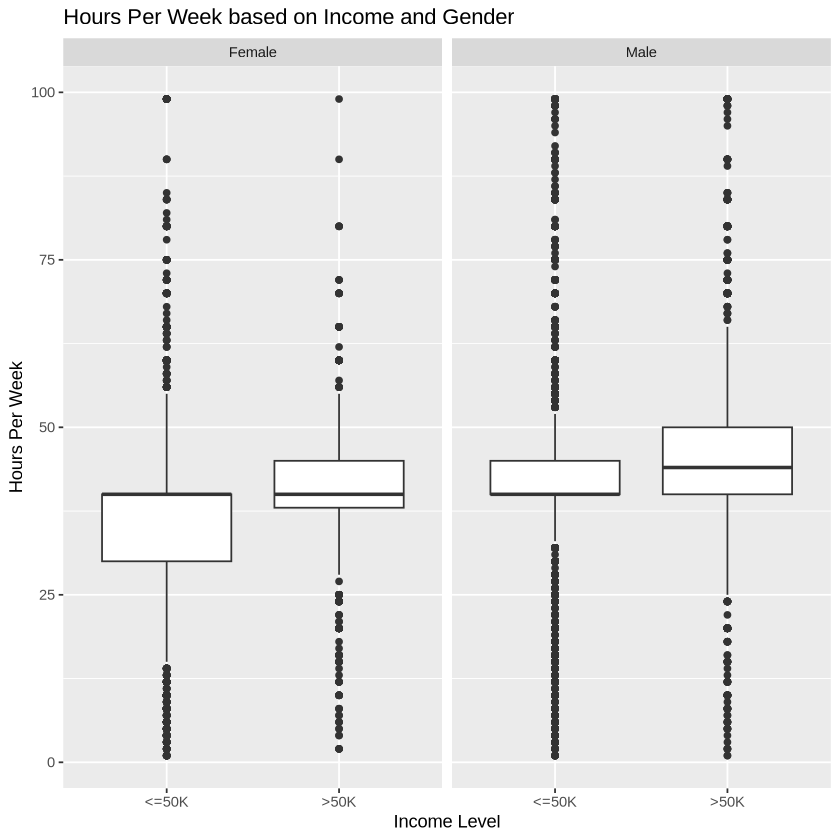

In [11]:
hours_per_week_sex_plot <- ggplot(adult_df, aes(x = income, y = hours.per.week)) +
                           geom_boxplot() +
                           labs(title = "Hours Per Week based on Income and Gender", x ="Income Level", y = "Hours Per Week") +
                           facet_wrap(~sex) 
hours_per_week_sex_plot             

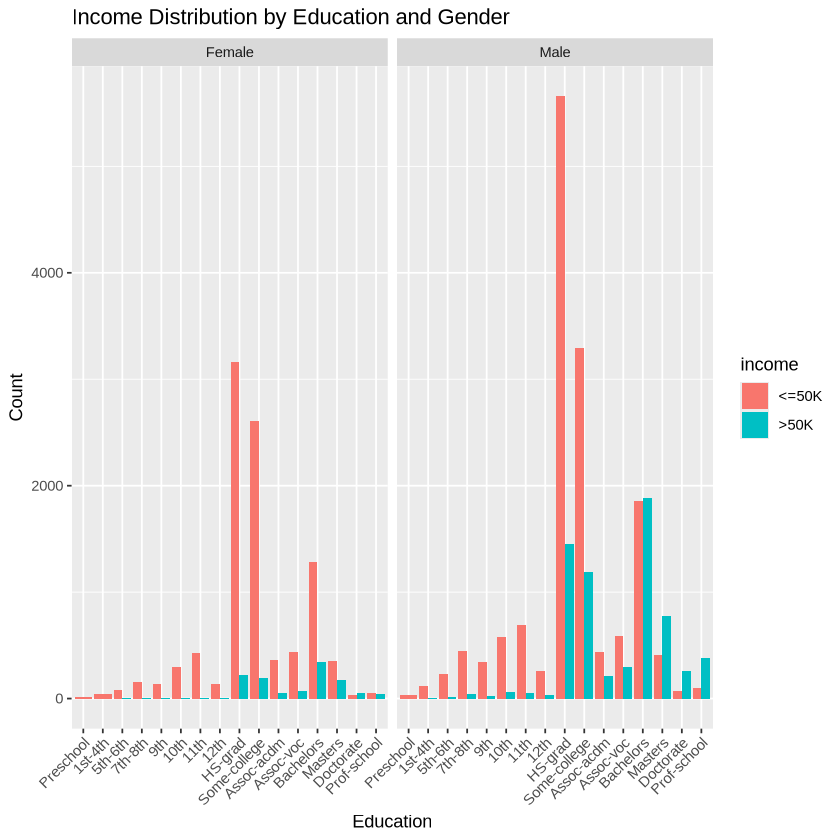

In [12]:
adult_df <- adult_df %>%
  mutate(education = fct_relevel(education, 
                                 "Preschool", "1st-4th", "5th-6th", "7th-8th", 
                                 "9th", "10th", "11th", "12th", "HS-grad", 
                                 "Some-college", "Assoc-acdm", "Assoc-voc", 
                                 "Bachelors", "Masters", "Doctorate"))

education_sex_income_plot <- ggplot(adult_df, aes(x = education, fill = income)) +
                              geom_bar(position = "dodge") +
                              facet_wrap(~sex) +
                              labs(title = "Income Distribution by Education and Gender", x = "Education", y = "Count") +
                              theme(axis.text.x = element_text(angle = 45, hjust = 1))
education_sex_income_plot

It seems for education, it looks around the same for both female and male bar graphs where we can see a trend where the higher the education level, the higher the proportions there is for 50k or greater income levels. 

### Methods and Plan

Before proprosing a model, we would first remove repetitive features that represent very identical factors to predict our response variable. For example, we have education and education level which, if we add both variables to our model, will only introduce more noise than predictive power. In addition, we know these two features have multicollinearity, thus removing one of them would be good. 

For our analysis of the Adult Census Income dataset, I propose using a Logistic Regression model to predict whether an individual's income exceeds $50K annually. Logistic regression is a robust and interpretable method for binary classification tasks, aligning well with our target variable, which has two categories: <=50K and >50K. 

#### Why This Method Is Appropriate

The target variable is binary, and logistic regression is designed to model the probability of an outcome as a function of explanatory variables. It allows us to interpret the relationship between predictor variables (e.g., age, hours.per.week, occupation) and the odds of earning more than $50K. Logistic regression is computationally efficient and scalable for a dataset of this size, which contains over 30,000 observations.


#### Variable Selection Method: Backward Selection

To select the most relevant predictors for the model, I propose using Backward Selection. This approach starts with all potential explanatory variables included in the model. Variables are removed one at a time based on a criterion such as p-values, until the best-fitting model is achieved. Below are reasons why backward selection is appropriate:

1. Exploratory Dataset: Backward selection is useful when starting with all variables makes sense, as we want to explore which predictors do not contribute significantly to the model.
2. Handling Redundancy: Backward selection helps identify and remove irrelevant or redundant predictors that may dilute the model’s accuracy or interpretability.
3. Simplicity: By iteratively reducing the number of variables, backward selection ensures the final model is parsimonious without overlooking complex interactions.

#### Assumptions of Logistic Regression

1. Binary Response: The response variable is dichotomous (two possible responses) or the sum of dichotomous responses.
2. Independence: The observations must be independent of one another.
3. Variance Structure: As response is biomial, the variance is np * (1 - p) by definition and the highest variance it can reach is when p = 0.5.
4. Linearity: The log odds $(\frac{p}{1 - p})$ must be a linear function of the predictor


#### Potential Limitations of the method itself

1. Computational Cost: Backward selection can be computationally expensive for datasets with many predictors, as it starts with all variables.
2. Risk of Overfitting: Removing variables based on p-values or AIC alone might lead to overfitting, especially in small samples.
3. Missed Interactions: Backward selection does not automatically explore variable interactions, which may reduce model performance.



### Implementation of the Proposed Model

In [13]:
head(adult_df)

age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
<dbl>,<chr>,<dbl>,<fct>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
90,Local-gov,77053,HS-grad,9,Widowed,Adm-clerical,Not-in-family,White,Female,0,4356,40,United-States,<=50K
82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
66,Private,186061,Some-college,10,Widowed,Farming-fishing,Unmarried,Black,Female,0,4356,40,United-States,<=50K
54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K


Removing these Features: 

- fnlwgt: I personaly do not know how they calculate this feature and in additon, it is not a characteristic of individuals but rather reflects sampling probabilities or demographic weights thus does not have a direct relationship with an individual's income level.
- education.num: We already have education, thus, this feature would just introduce noise to the model
- race: It might introduce ethical concerns or bias in the model which we do not want our model to be trained on.

In [14]:
adult_df <- adult_df |>
select(-fnlwgt, -education.num, -race)

In [18]:
adult_df$income <- ifelse(adult_df$income == ">50K", 1, 0)

head(adult_df)

age,workclass,education,marital.status,occupation,relationship,sex,capital.gain,capital.loss,hours.per.week,native.country,income
<dbl>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
90,Local-gov,HS-grad,Widowed,Adm-clerical,Not-in-family,Female,0,4356,40,United-States,0
82,Private,HS-grad,Widowed,Exec-managerial,Not-in-family,Female,0,4356,18,United-States,0
66,Private,Some-college,Widowed,Farming-fishing,Unmarried,Female,0,4356,40,United-States,0
54,Private,7th-8th,Divorced,Machine-op-inspct,Unmarried,Female,0,3900,40,United-States,0
41,Private,Some-college,Separated,Prof-specialty,Own-child,Female,0,3900,40,United-States,0
34,Private,HS-grad,Divorced,Other-service,Unmarried,Female,0,3770,45,United-States,0


#### Splitting the dataset into train and testing portions

In [33]:
set.seed(123)

adult_df$income <- as.factor(adult_df$income)

unique_levels <- sapply(adult_df, function(x) length(unique(x)))
print(unique_levels)


adult_df <- adult_df[, unique_levels > 1]

training_adult <- adult_df %>%
  sample_frac(0.6)

testing_adult <- adult_df %>%
  setdiff(training_adult)

           age      workclass      education marital.status     occupation 
            73              8             16              7             14 
  relationship            sex   capital.gain   capital.loss hours.per.week 
             6              2            119             92             94 
native.country         income 
            41              2 


#### Backward Selection

In [37]:
adult_backward_sel <- regsubsets(
  x = income ~ .,                
  data = training_adult,           
  nvmax = ncol(training_adult) - 1,                    
  method = "backward"             
)

adult_backward_summary <- summary(adult_backward_sel)
best_model_size <- which.max(adult_backward_summary$adjr2)

best_model_coefs <- coef(adult_backward_sel, id = best_model_size)

best_model_coefs_df <- as.data.frame(best_model_coefs)
colnames(best_model_coefs_df) <- "Coefficient"

cat("Coefficients for the best model:\n")
print(best_model_coefs_df)

Coefficients for the best model:
                             Coefficient
(Intercept)                 1.330433e+00
educationBachelors          1.736212e-01
educationMasters            2.763006e-01
educationDoctorate          4.189453e-01
educationProf-school        3.665224e-01
occupationExec-managerial   1.375616e-01
relationshipNot-in-family  -3.259382e-01
relationshipOther-relative -3.336103e-01
relationshipOwn-child      -3.541414e-01
relationshipUnmarried      -3.247812e-01
capital.gain                8.530964e-06
capital.loss                1.017051e-04


#### Logistic Regression

In [46]:
final_predictors <- make.names(names(best_model_coefs)[-1])
final_predictors

[1] "educationBachelors"         "educationMasters"          
 [3] "educationDoctorate"         "educationProf.school"      
 [5] "occupationExec.managerial"  "relationshipNot.in.family" 
 [7] "relationshipOther.relative" "relationshipOwn.child"     
 [9] "relationshipUnmarried"      "capital.gain"              
[11] "capital.loss"

Since we see parts of education, occupation, relationship and capital gain and capital loss to be the most important variables, we will use them for our final model. An interesting observation as well is that sex is not a part of the most important variable.

In [48]:
final_model <- glm(income ~ education + marital.status +  occupation + relationship + capital.gain + capital.loss, data = training_adult, family = binomial)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


summary(final_model)

In [55]:
predicted_probs <- predict(final_model, newdata = testing_adult, type = "response")

# Convert probabilities to class predictions (threshold = 0.5)
predicted_classes <- ifelse(predicted_probs > 0.5, 1, 0)

# Create a confusion matrix
confusion_matrix <- table(Actual = testing_adult$income, Predicted = predicted_classes)
cat("Confusion Matrix:\n")
print(confusion_matrix)

# Calculate accuracy
accuracy <- sum(diag(confusion_matrix)) / sum(confusion_matrix)
cat("Accuracy:", round(accuracy, 4), "\n")

Confusion Matrix:
      Predicted
Actual    0    1
     0 7306  629
     1 1154 1601
Accuracy: 0.8332 
